In [1]:
### General analysis package
import os
import time
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### Drawing package
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
#import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # Output editable PDF text
### else
#import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # Error alert
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score

import math
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as TorchData
from torchmetrics import Accuracy
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from imblearn.over_sampling import RandomOverSampler, SMOTE

import warnings
warnings.filterwarnings('ignore')

SEED = 42
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

print("Using torch", torch.__version__)

Using torch 1.10.1


# 1.Modeling data

In [1]:
path = 'Breast cancer/'
data = pd.read_csv(path+'E-GEOD-73002.csv', index_col=0)
data = data.fillna(0)
data['Label'] = [1 if i == 'Breast Cancer' else 0 for i in list(data['Label'])]
'# Feature number (microRNA) = ' + str(data.shape[1])

NameError: name 'pd' is not defined

# 样本数量 ：Cancer = 1280; Normal = 2833


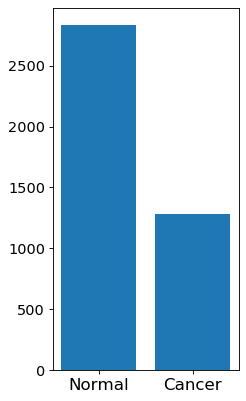

In [4]:
print('# sample size ：Cancer = '+str(list(data['Label']).count(1))+'; Normal = '+str(list(data['Label']).count(0)))
fig = plt.figure(1, (3, 6), dpi=80)
_ = plt.bar([0, 1], [list(data['Label']).count(0), list(data['Label']).count(1)])
_ = plt.xticks([0, 1], ['Normal', 'Cancer'], fontsize=15)
_ = plt.yticks(fontsize=13)
_ = plt.show()
fig.savefig('20220610_Results/1. Data distribution.pdf', dpi=300)

# 2. Data segmentation, training test

'训练集: (2467, 2540)([1699, 768]); 测试集: (1646, 2540)([1134, 512])'

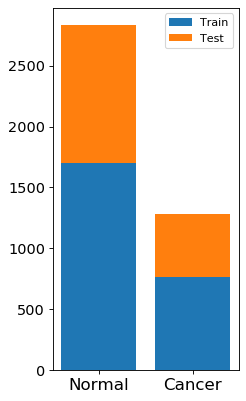

In [5]:
cv = model_selection.StratifiedShuffleSplit(n_splits=2, test_size=.4, random_state=SEED)
X = data.iloc[:, :-1]
y = data['Label']
for train_index, test_index in cv.split(X, y):pass
X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
f'Training set: {X_train.shape}({[(y_train==i).sum() for i in [0, 1]]}); Test set: {X_test.shape}({[(y_test==i).sum() for i in [0, 1]]})'

fig = plt.figure(1, (3, 6), dpi=80)
_ = plt.bar([0, 1], [list(y_train).count(0), list(y_train).count(1)], label='Train')
_ = plt.bar([0, 1], [list(y_test).count(0), list(y_test).count(1)],
            bottom=[list(y_train).count(0), list(y_train).count(1)], label='Test')
_ = plt.legend()
_ = plt.xticks([0, 1], ['Normal', 'Cancer'], fontsize=15)
_ = plt.yticks(fontsize=13)
_ = plt.show()
fig.savefig('20220610_Results/1. Datadistribution_trainingtest.pdf', dpi=300)

In [6]:
X_train.to_csv('20220610_Results/1. X_train.csv', index=True)
X_test.to_csv('20220610_Results/1. X_test.csv', index=True)
y_train.to_csv('20220610_Results/1. y_train.csv', index=True)
y_test.to_csv('20220610_Results/1. y_test.csv', index=True)

# 3. Training dataoversampling

In [7]:
### Oversampling
ros = RandomOverSampler(random_state=SEED)
#ros = SMOTE()
#ros = ADASYN()
X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_ros.shape
X_ros.to_csv('20220610_Results/1. X_train_ros.csv', index=True)
y_ros.to_csv('20220610_Results/1. y_train_ros.csv', index=True)

(3398, 2540)

In [8]:
ros = SMOTE()
X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_ros.shape
X_ros.to_csv('20220610_Results/1. X_train_SMOTE.csv', index=True)
y_ros.to_csv('20220610_Results/1. y_train_SMOTE.csv', index=True)

(3398, 2540)

# 4. External data（Kaggle）

In [11]:
#print(cont_names)
vali_data = pd.read_csv(path+'KaggleData/GSE58606_data.csv')
vali_data.head(2)
columns = [str(i).split(':')[1].strip() for i in list(vali_data.columns)[:-2]]
columns.extend(['Label', 'Disease'])
vali_data.columns = columns
label = vali_data['Label']
print(len(vali_data.columns), len(X.columns), len(set(vali_data.columns)&set(X.columns)))
vali_data.to_csv('20220610_Results/1. GSE58606.csv')

,4040 : hsa-miR-9-5p,4610 : hsa-miR-126-3p,4700 : hsa-miR-140-5p,5250 : hsa-miR-105-5p,6880 : hsa-miR-297,9938 : hsa-let-7i-5p,10138 : hsa-miR-130a-3p,10306 : hsa-miR-146b-5p,10901 : hsa_negative_control_6,10902 : hsa_negative_control_7,...,169411 : hsa-miR-205-3p,169412 : hsa-miR-1260a,169414 : hsa-miR-525-5p,169415 : hsa-miR-187-5p,169416 : hsa-miRPlus-A1086,169417 : hsa-miR-551b-5p,169419 : hsa-miR-300,169420 : hsa-miR-193b-5p,target,target_actual
0,6.877643,8.080215,6.245265,6.304782,6.686064,7.805950,6.814781,7.146955,6.170680,6.129586,...,7.176684,7.724408,6.035476,6.255048,6.572019,6.251777,5.873303,6.362097,1,primary breast cancer
1,6.544287,6.882722,5.874236,6.324987,6.638048,6.946567,6.488574,6.690773,6.160272,6.104929,...,7.249094,7.308890,6.021796,6.902473,6.347183,6.625569,6.004899,6.560329,1,primary breast cancer


1928 2540 1735


In [12]:
diff_up = pd.read_csv(path+'DEG/Micro_up.csv', index_col=0)
diff_dn = pd.read_csv(path+'DEG/Micro_down.csv', index_col=0)
diffs = list(diff_up.index)+list(diff_dn.index)
len(diffs)
diffs = [i.replace('.', '-').replace('p-hsa', 'p;hsa') for i in diffs]

710

In [13]:
len(set(diffs)&set(vali_data.columns))

523

In [14]:
len(set(diffs)&set(X.columns))

710

In [15]:
diff_res = pd.concat([diff_up, diff_dn], axis=0, sort=False)
diff_res['ID'] = diffs
diff_res.to_csv('20220610_Results/1. diff_microRNA(FC2_FDR0.05).csv')